In [19]:
import pandas as pd
import numpy as np
from scipy.spatial import cKDTree
from datetime import datetime
from sklearn.metrics import root_mean_squared_error, r2_score
from haversine import haversine_vector, Unit
import glob
import xarray as xr
import polars as pl
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Get list of NetCDF files
nc_files = glob.glob("C:/Users/flapet/OneDrive - NOC/Documents/IDAPro/lib/db_building/data/glider/nc_profiled/*.nc")

# Read and concatenate datasets
for file in nc_files:
    ds = xr.open_dataset(file, decode_times=True)
    glider_name = ds.attrs.get("trajectory").split("_")[0]
    # Select variables of interest
    vars_of_interest = ["TIME", "DEPTH", "TEMP", "CHLA", "BBP700", "ABS_SALINITY", "MOLAR_DOXY", "PROFILE_NUMBER", "LATITUDE", "LONGITUDE"]
    ds_sel = ds[vars_of_interest]
    # Convert to pandas DataFrame, then to polars DataFrame
    df_pd = ds_sel.to_dataframe().reset_index()
    df_pl = pl.from_pandas(df_pd)

    #Use only profiling data (-1 is surfacing behavior)
    df_pl = df_pl.filter(pl.col("PROFILE_NUMBER") > 0)

    df_pl = df_pl.with_columns((pl.col("PROFILE_NUMBER").cast(pl.String) + "_" + glider_name).alias("profile_id"))
    print(f"{file} processed, shape: {df_pl.shape}")

    # Concatenate DataFrames
    if 'df_concat' in locals():
        df_concat = pl.concat([df_concat, df_pl])
    else:
        df_concat = df_pl

# Add a 'glider_name' column by extracting the part before '_' in 'profile_id'
df_concat = df_concat.with_columns(
    pl.col("profile_id").str.split("_").list.get(1).alias("glider_name")
)

C:/Users/flapet/OneDrive - NOC/Documents/IDAPro/lib/db_building/data/glider/nc_profiled\Cabot_645_Profiled.nc processed, shape: (1438541, 12)
C:/Users/flapet/OneDrive - NOC/Documents/IDAPro/lib/db_building/data/glider/nc_profiled\Churchill_647_Profiled.nc processed, shape: (1142019, 12)
C:/Users/flapet/OneDrive - NOC/Documents/IDAPro/lib/db_building/data/glider/nc_profiled\Doombar_648_Profiled.nc processed, shape: (1952630, 12)
C:/Users/flapet/OneDrive - NOC/Documents/IDAPro/lib/db_building/data/glider/nc_profiled\Nelson_646_Profiled.nc processed, shape: (1951435, 12)


In [3]:
df_concat = (
    df_concat
    .sort(['profile_id', 'TIME'])
    .with_columns([
        pl.col('DEPTH')
        .interpolate()
        .over('profile_id')
        .alias('DEPTH')
    ])
)
df = df_concat.to_pandas().copy()


In [4]:

df = df.dropna(subset=["DEPTH", "LONGITUDE", "LATITUDE", "TIME"])
# Split by glider
df_cabot = df[df['profile_id'].str.contains("Cabot")]
df_churchill = df[df['profile_id'].str.contains("Churchill")]

df_cabot['depth_bin'] = (df_cabot['DEPTH'] // 2 * 2).astype(int)
df_churchill['depth_bin'] = (df_churchill['DEPTH'] // 2 * 2).astype(int)

df_cabot_binned = df_cabot.groupby(['profile_id', 'depth_bin'])[["TEMP", "ABS_SALINITY", "CHLA", "MOLAR_DOXY", "BBP700"]].median().reset_index()
df_cabot_binned = df_cabot_binned.dropna(subset=["TEMP", "ABS_SALINITY", "CHLA", "MOLAR_DOXY", "BBP700"])
df_churchill_binned = df_churchill.groupby(['profile_id', 'depth_bin'])[["TEMP", "ABS_SALINITY", "CHLA", "MOLAR_DOXY", "BBP700"]].median().reset_index()
df_churchill_binned = df_churchill_binned.dropna(subset=["TEMP", "ABS_SALINITY", "CHLA", "MOLAR_DOXY", "BBP700"])

C:\Users\flapet\AppData\Local\Temp\ipykernel_17620\1798875941.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cabot['depth_bin'] = (df_cabot['DEPTH'] // 2 * 2).astype(int)
C:\Users\flapet\AppData\Local\Temp\ipykernel_17620\1798875941.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_churchill['depth_bin'] = (df_churchill['DEPTH'] // 2 * 2).astype(int)


In [5]:
def profile_metadata(df):
    meta = df.groupby(['profile_id']).agg({
        'LATITUDE': 'first',
        'LONGITUDE': 'first',
        'TIME': 'first'
    }).reset_index()
    meta['time_days'] = (meta['TIME'] - meta['TIME'].min()).dt.total_seconds() / 86400
    return meta

meta = profile_metadata(df)

In [6]:
meta_cabot = meta[meta['profile_id'].str.contains("Cabot")]
meta_churchill = meta[meta['profile_id'].str.contains("Churchill")]

# Convert time to days since start
t0 = min(df['TIME'])
df_cabot['time_days'] = (df_cabot['TIME'] - t0).dt.total_seconds() / 86400
df_churchill['time_days'] = (df_churchill['TIME'] - t0).dt.total_seconds() / 86400

C:\Users\flapet\AppData\Local\Temp\ipykernel_17620\3891187339.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cabot['time_days'] = (df_cabot['TIME'] - t0).dt.total_seconds() / 86400
C:\Users\flapet\AppData\Local\Temp\ipykernel_17620\3891187339.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_churchill['time_days'] = (df_churchill['TIME'] - t0).dt.total_seconds() / 86400


KDtree matching function

In [30]:
def match_profiles(meta_A, meta_B, alpha=10, max_dist_km=50):
    """
    Match profiles between meta_A and meta_B using a combined space-time distance.
    
    Parameters:
    - alpha: km/day scaling factor for time
    - max_dist_km: maximum combined distance in km
    
    Returns:
    - Filtered matched profiles from A and B
    """
    # Build scaled 3D coordinates: lat, lon, and scaled time
    coords_A = np.column_stack([
        meta_A['LATITUDE'],
        meta_A['LONGITUDE'],
        meta_A['time_days'] * alpha  # time scaled to km
    ])
    coords_B = np.column_stack([
        meta_B['LATITUDE'],
        meta_B['LONGITUDE'],
        meta_B['time_days'] * alpha
    ])
    
    tree_B = cKDTree(coords_B)
    dist, idx = tree_B.query(coords_A, k=1)  # combined distance

    # Retrieve matched rows
    matched_B = meta_B.iloc[idx].reset_index(drop=True)

    # Filter by combined spatio-temporal distance
    mask = dist <= max_dist_km

    return meta_A[mask].reset_index(drop=True), matched_B[mask].reset_index(drop=True)


Profile comparison

In [35]:
def compare_profiles(df_A, df_B, meta_A, meta_B, var):
    rmse_list = []
    r2_list = []

    var_a = var + "_a"
    var_b = var + "_b"
    for i in range(len(meta_A)):
        pa = df_A[df_A['profile_id'] == meta_A.iloc[i]['profile_id']]
        pb = df_B[df_B['profile_id'] == meta_B.iloc[i]['profile_id']]

        merged = pd.merge(pa[['depth_bin', var]], pb[['depth_bin', var]], on='depth_bin', suffixes=('_a', '_b'))
        if len(merged) > 10:
            rmse = root_mean_squared_error(merged[var_a], merged[var_b])
            rmse_list.append(rmse)

            r2 = r2_score(merged[var_a], merged[var_b])
            r2_list.append(r2)
        else:
            rmse_list.append(np.nan)
            r2_list.append(np.nan)
    
    # Convert to arrays
    r2_array = np.array(r2_list)

    # Compute median R² over valid (non-NaN) entries
    valid_r2 = r2_array[~np.isnan(r2_array)]
    median_r2 = np.median(valid_r2) if len(valid_r2) > 0 else np.nan


    return np.array(rmse_list), np.array(median_r2)

In [26]:
def compare_profiles2(df_A, df_B, meta_A, meta_B, var):
    temps_a_all = []
    temps_b_all = []
    depth_all = []

    var_a = var + '_a'
    var_b = var + '_b'

    for i in range(len(meta_A)):
        pid_a = meta_A.iloc[i]['profile_id']
        pid_b = meta_B.iloc[i]['profile_id']

        prof_a = df_A[df_A['profile_id'] == pid_a]
        prof_b = df_B[df_B['profile_id'] == pid_b]

        merged = pd.merge(
            prof_a[['depth_bin', var]],
            prof_b[['depth_bin', var]],
            on='depth_bin',
            suffixes=('_a', '_b')
        )

        if len(merged) >= 10:
            temps_a_all.extend(merged[var_a].values)
            temps_b_all.extend(merged[var_b].values)
            depth_all.extend(merged['depth_bin'].values)

    if len(temps_a_all) == 0:
        print("No valid profile matches with sufficient depth overlap.")
        return

    # Convert to numpy arrays
    x = np.array(temps_a_all)
    y = np.array(temps_b_all)
    z = np.array(depth_all)

    # Compute stats
    rmse = root_mean_squared_error(x, y)
    r2 = r2_score(x, y)
    return rmse, r2

In [25]:
best_score = 0
best_params = None

time_scales = np.linspace(5, 30, 5)        # km/day

for t_scale in time_scales:
    matched_A, matched_B = match_profiles(meta_cabot.copy(), meta_churchill.copy(), t_scale, max_days=1, max_km=30)
    print(f"{len(matched_A)} profile pairs matched within 2 days and 50 km.")
    avg_rmse, avg_r2 = compare_profiles2(df_cabot_binned, df_churchill_binned, matched_A, matched_B, 'TEMP')
    if avg_r2 > best_score:
        best_score = avg_r2
        best_rmse = avg_rmse
        best_params = t_scale

print(f"Best scale: time = {best_params:.2f} km/day, R2 = {best_score:.2f}")
print(f"Best RMSE = {best_rmse:.3f}, mean R² = {best_score:.2f}")


539 profile pairs matched within 2 days and 50 km.
539 profile pairs matched within 2 days and 50 km.
539 profile pairs matched within 2 days and 50 km.
539 profile pairs matched within 2 days and 50 km.
539 profile pairs matched within 2 days and 50 km.
Best scale: time = 5.00 km/day, R2 = 0.87
Best RMSE = 0.187, mean R² = 0.87


In [15]:
def plot_all_matched_scatter(df_A, df_B, meta_A, meta_B):
    temps_a_all = []
    temps_b_all = []
    depth_all = []

    for i in range(len(meta_A)):
        pid_a = meta_A.iloc[i]['profile_id']
        pid_b = meta_B.iloc[i]['profile_id']

        prof_a = df_A[df_A['profile_id'] == pid_a]
        prof_b = df_B[df_B['profile_id'] == pid_b]

        merged = pd.merge(
            prof_a[['depth_bin', 'CHLA']],
            prof_b[['depth_bin', 'CHLA']],
            on='depth_bin',
            suffixes=('_a', '_b')
        )

        if len(merged) >= 10:
            temps_a_all.extend(merged['CHLA_a'].values)
            temps_b_all.extend(merged['CHLA_b'].values)
            depth_all.extend(merged['depth_bin'].values)

    if len(temps_a_all) == 0:
        print("No valid profile matches with sufficient depth overlap.")
        return

    # Convert to numpy arrays
    x = np.array(temps_a_all)
    y = np.array(temps_b_all)
    z = np.array(depth_all)

    # Compute stats
    rmse = root_mean_squared_error(x, y)
    r2 = r2_score(x, y)
    r, _ = pearsonr(x, y)

    # Scatter plot
    plt.figure(figsize=(7, 7))
    sc = plt.scatter(x, y, c=z, cmap='viridis', s=30, alpha=0.7, edgecolor='k', linewidth=0.3)
    plt.plot([min(x), max(x)], [min(x), max(x)], 'r--', label='1:1 line')
    plt.xlabel('Temperature (°C) - Glider A')
    plt.ylabel('Temperature (°C) - Glider B')
    plt.title(f'All Matched Profile Points\n(RMSE={rmse:.2f}, R²={r2:.2f}, r={r:.2f})')

    cbar = plt.colorbar(sc)
    cbar.set_label('Depth (m)')
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()


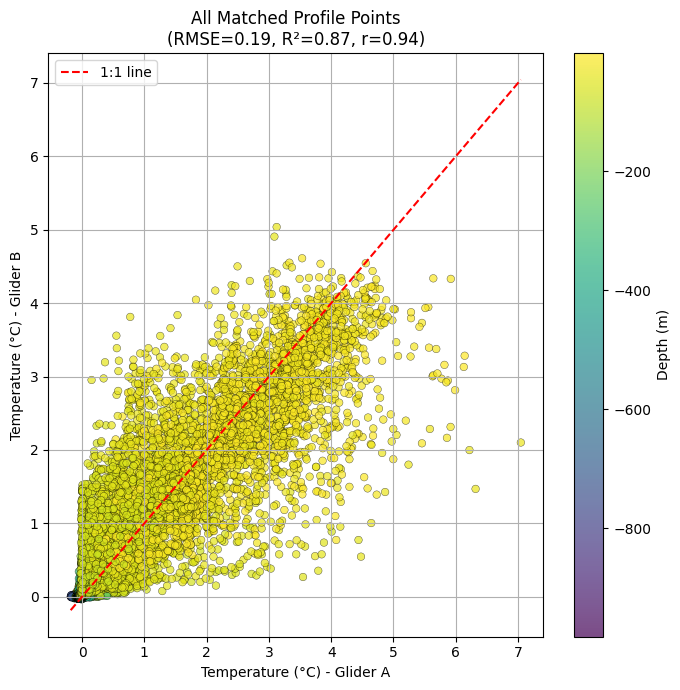

In [20]:
matched_A, matched_B = match_profiles(meta_cabot.copy(), meta_churchill.copy(), 17.5, max_days=1, max_km=30)
plot_all_matched_scatter(df_cabot_binned, df_churchill_binned, matched_A, matched_B)

Time scale: 1.00 km/day, Variable: TEMP, Mean R²: 0.95
Time scale: 1.00 km/day, Variable: ABS_SALINITY, Mean R²: 0.69
Time scale: 1.00 km/day, Variable: CHLA, Mean R²: 0.86
Time scale: 1.00 km/day, Variable: MOLAR_DOXY, Mean R²: 0.76
Time scale: 1.00 km/day, Variable: BBP700, Mean R²: 0.16
Time scale: 13.25 km/day, Variable: TEMP, Mean R²: 0.95
Time scale: 13.25 km/day, Variable: ABS_SALINITY, Mean R²: 0.70
Time scale: 13.25 km/day, Variable: CHLA, Mean R²: 0.87
Time scale: 13.25 km/day, Variable: MOLAR_DOXY, Mean R²: 0.77
Time scale: 13.25 km/day, Variable: BBP700, Mean R²: 0.18
Time scale: 25.50 km/day, Variable: TEMP, Mean R²: 0.95
Time scale: 25.50 km/day, Variable: ABS_SALINITY, Mean R²: 0.70
Time scale: 25.50 km/day, Variable: CHLA, Mean R²: 0.87
Time scale: 25.50 km/day, Variable: MOLAR_DOXY, Mean R²: 0.77
Time scale: 25.50 km/day, Variable: BBP700, Mean R²: 0.18
Time scale: 37.75 km/day, Variable: TEMP, Mean R²: 0.95
Time scale: 37.75 km/day, Variable: ABS_SALINITY, Mean R²: 0.

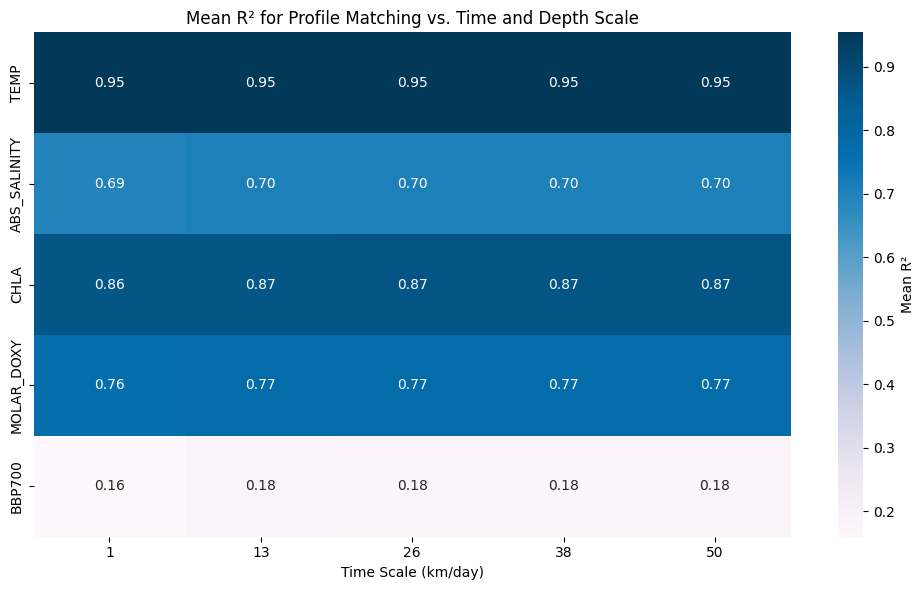

In [28]:
import matplotlib.pyplot as plt
import seaborn as sns

# Define grid
time_scales = np.linspace(1, 50, 5)        # km/day
varlist = ["TEMP", "ABS_SALINITY", "CHLA", "MOLAR_DOXY", "BBP700"]   # km/m

# Store R² values
r2_matrix = np.full((len(varlist), len(time_scales)), np.nan)

# Fill matrix with mean R²
for i, t_scale in enumerate(time_scales):
    for j, var in enumerate(varlist):
        matched_A, matched_B = match_profiles(meta_cabot.copy(), meta_churchill.copy(), t_scale, max_days=1, max_km=50)
        rmse_vals, avg_r2 = compare_profiles2(df_cabot_binned, df_churchill_binned, matched_A, matched_B, var)
        r2_matrix[j, i] = avg_r2
        print(f"Time scale: {t_scale:.2f} km/day, Variable: {var}, Mean R²: {r2_matrix[j, i]:.2f}")

# Plot heatmap
plt.figure(figsize=(10, 6))
# Replace NaN values with a placeholder (e.g., 0) or use interpolation
r2_matrix_cleaned = np.nan_to_num(r2_matrix, nan=0)

sns.heatmap(r2_matrix_cleaned, xticklabels=[f"{s:.0f}" for s in time_scales],
            yticklabels=varlist,
            cmap="PuBu", annot=True, fmt=".2f", cbar_kws={'label': 'Mean R²'})

plt.title("Mean R² for Profile Matching vs. Time and Depth Scale")
plt.xlabel("Time Scale (km/day)")
plt.ylabel("")
plt.tight_layout()
plt.show()

Max dist: 100.00 km, Variable: TEMP, Mean R²: 0.98
Max dist: 100.00 km, Variable: ABS_SALINITY, Mean R²: 0.65
Max dist: 100.00 km, Variable: CHLA, Mean R²: 0.88
Max dist: 100.00 km, Variable: MOLAR_DOXY, Mean R²: 0.78
Max dist: 325.00 km, Variable: TEMP, Mean R²: 0.98
Max dist: 325.00 km, Variable: ABS_SALINITY, Mean R²: 0.65
Max dist: 325.00 km, Variable: CHLA, Mean R²: 0.88
Max dist: 325.00 km, Variable: MOLAR_DOXY, Mean R²: 0.78
Max dist: 550.00 km, Variable: TEMP, Mean R²: 0.98
Max dist: 550.00 km, Variable: ABS_SALINITY, Mean R²: 0.65
Max dist: 550.00 km, Variable: CHLA, Mean R²: 0.88
Max dist: 550.00 km, Variable: MOLAR_DOXY, Mean R²: 0.78
Max dist: 775.00 km, Variable: TEMP, Mean R²: 0.98
Max dist: 775.00 km, Variable: ABS_SALINITY, Mean R²: 0.65
Max dist: 775.00 km, Variable: CHLA, Mean R²: 0.88
Max dist: 775.00 km, Variable: MOLAR_DOXY, Mean R²: 0.78
Max dist: 1000.00 km, Variable: TEMP, Mean R²: 0.98
Max dist: 1000.00 km, Variable: ABS_SALINITY, Mean R²: 0.65
Max dist: 1000.0

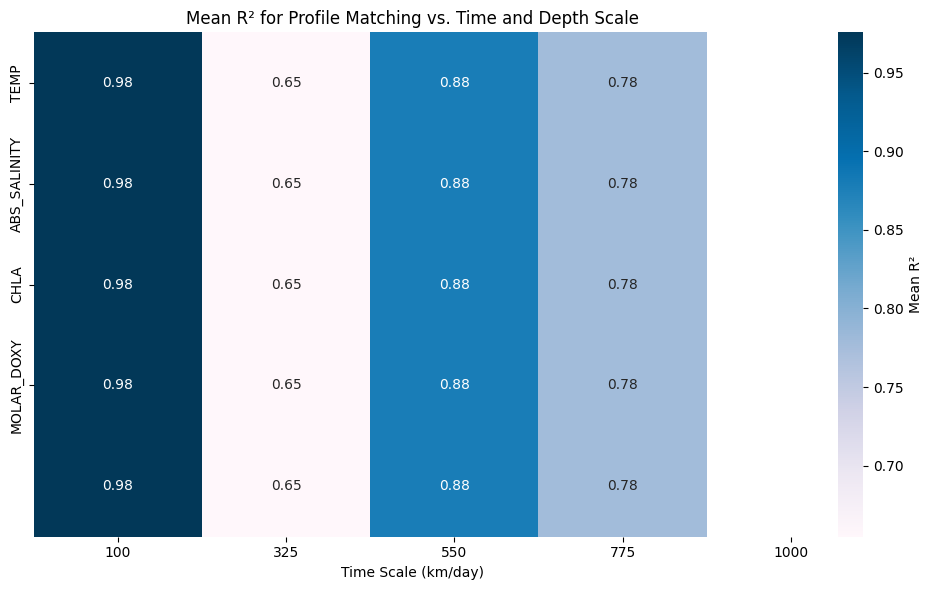

In [36]:
# Define grid
max_km_list = np.linspace(100, 1000, 5)        # km/day
varlist = ["TEMP", "ABS_SALINITY", "CHLA", "MOLAR_DOXY"]   # km/m

# Store R² values
r2_matrix = np.full((len(max_days_list), len(varlist)), np.nan)
# Fill matrix with mean R²
for i, max_km in enumerate(max_km_list):
    for j, var in enumerate(varlist):
        matched_A, matched_B = match_profiles(meta_cabot.copy(), meta_churchill.copy(), 20, max_dist_km=max_km)
        rmse_vals, avg_r2 = compare_profiles(df_cabot_binned, df_churchill_binned, matched_A, matched_B, var)
        r2_matrix[i, j] = avg_r2
        print(f"Max dist: {max_km:.2f} km, Variable: {var}, Mean R²: {r2_matrix[i, j]:.2f}")

# Plot heatmap
plt.figure(figsize=(10, 6))
# Replace NaN values with a placeholder (e.g., 0) or use interpolation
r2_matrix_cleaned = np.nan_to_num(r2_matrix, nan=0)

sns.heatmap(r2_matrix_cleaned, xticklabels=[f"{s:.0f}" for s in max_km_list],
            yticklabels=varlist,
            cmap="PuBu", annot=True, fmt=".2f", cbar_kws={'label': 'Mean R²'})

plt.title("Mean R² for Profile Matching vs. Time and Depth Scale")
plt.xlabel("Time Scale (km/day)")
plt.ylabel("")
plt.tight_layout()
plt.show()